# Validação do Modelo Identificado

In [103]:
import matplotlib.pyplot as plt

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import control as ct
import scipy
import scipy.signal as sg
import control.matlab as ctm
from sklearn.metrics import mean_squared_error
import scienceplots

#!pip install scienceplots

%config InlineBackend.figure_format='retina'
plt.style.use(["science", "notebook"])


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

## Parâmetros de Ensaio

>> Offset = 1V\
>> Frequência do sinal de referência: 0.2 Hz\
>> Amplitude do sinal: 10°\
>> Periodo de amostragem do sinal: 0.02

In [104]:
# (url github) https://github.com/Oseiasdfarias/Projeto_Tcc_Oseias_Oficial/blob/main/interface_aeropendulo/interface/dados_de_ensaio/arquivo_25_6_2023_16_20_28.csv
# file = "../../../interface_aeropendulo/src_interface/dados_de_ensaio/arquivo_13_9_2023_23_48_56.csv"
file = "../../../interface_aeropendulo/src_interface/dados_de_ensaio/arquivo_14_9_2023_20_31_13.csv"
dados_malha_aberta = pd.read_csv(file, header=None, sep=',').values
dados_malha_aberta[0][0] = 0.0
dados_malha_aberta

array([[0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 4.00000e+00,
        5.00000e+00, 6.00000e+00],
       [0.00000e+00, 3.10000e+01, 3.06590e+01, ..., 1.00000e+00,
        1.00000e+00, 3.11810e+01],
       [1.00000e+00, 3.10000e+01, 3.07250e+01, ..., 1.00000e+00,
        1.00000e+00, 3.12010e+01],
       ...,
       [4.32100e+03, 3.10000e+01, 3.07910e+01, ..., 1.00000e+00,
        1.00000e+00, 1.17592e+02],
       [4.32200e+03, 3.10000e+01, 3.08570e+01, ..., 1.00000e+00,
        1.00000e+00, 1.17612e+02],
       [4.32300e+03, 3.10000e+01, 3.09230e+01, ..., 1.00000e+00,
        1.00000e+00, 1.17632e+02]])

In [105]:
tempo = np.array(dados_malha_aberta[:,7])
sinal_entrada  = np.array(dados_malha_aberta[:,1])
sinal_saida = np.array(dados_malha_aberta[:,2])

# Convertendo o sinal de Graus para Radianos
sinal_saida = np.squeeze(np.deg2rad(sinal_saida[50:]))
sinal_entrada = np.squeeze(np.deg2rad(sinal_entrada[50:]))
tempo = tempo[50:] - min(tempo[50:])

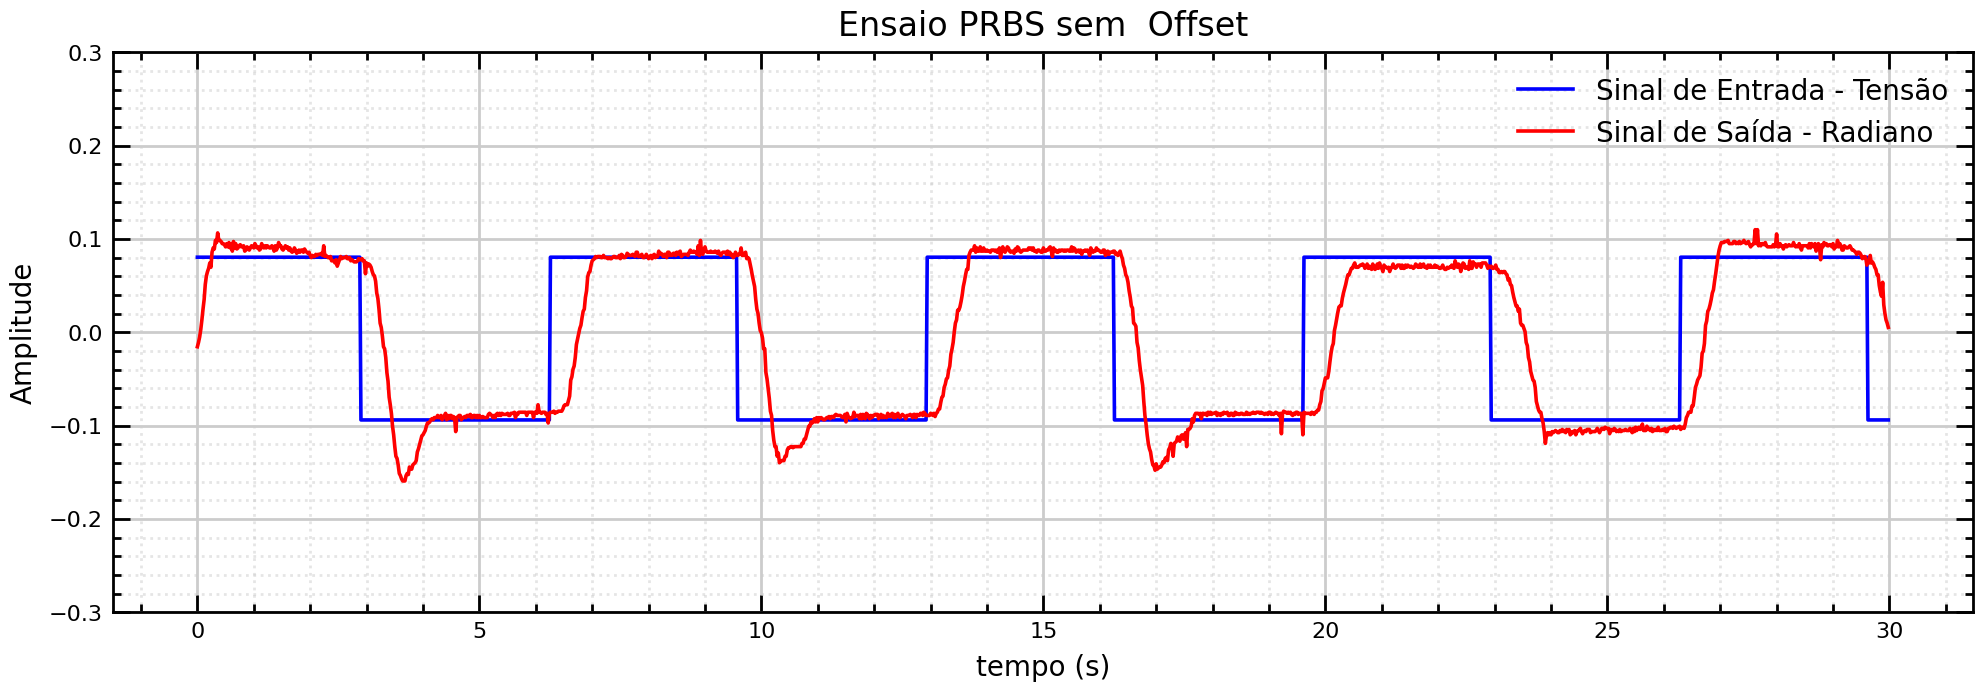

In [106]:
plt.figure(figsize=(12, 8))
plt.subplot(211)

intend = 1500

plt.plot(tempo[:intend], sinal_entrada[:intend] - np.mean(sinal_entrada[:intend]),
         c = 'b', lw=1.3, label = "Sinal de Entrada - Tensão")
plt.plot(tempo[:intend], (sinal_saida[:intend]) - np.mean((sinal_saida[:intend])),
         c = 'r', lw=1.3, label = "Sinal de Saída - Radiano")

plt. title('Ensaio PRBS sem  Offset', fontsize=12)
plt.ylabel('Amplitude', fontsize=10)
plt.xlabel('tempo (s)', fontsize=10)
plt.legend(fontsize=10)
plt.yticks(np.arange(-0.3, 0.4, 0.1))

plt.grid(which='both')
plt.grid(which='major', color='#CCCCCC', linestyle='-', alpha=1)
plt.grid(which='minor', color='#CCCCCC', linestyle=':', alpha=0.5)

plt.show()

## Modelo

Modelo Discreto

$$\frac{-0.002414 z + 0.01115}{z^5 - 0.9485 z^4 - 0.3122 z^3 - 0.007337 z^2 + 0.1263 z + 0.1573}\quad dt = 0.02$$

In [107]:
num_z = np.array([-0.002414, 0.01115])
den_z = np.array([1, -0.9485, -0.3122, -0.007337, 0.1263, 0.1573])
Gz = ct.tf(num_z, den_z, 0.02)
Gz

TransferFunction(array([-0.002414,  0.01115 ]), array([ 1.      , -0.9485  , -0.3122  , -0.007337,  0.1263  ,  0.1573  ]), 0.02)

Proximação de um Modelo Continuo a partir do modelo discreto

$$\displaystyle \frac{0.008736}{0.0009883437 s^{2} + 0.00668674000000001 s + 0.015563}$$

In [108]:
num_c = np.array([0.008736])
den_c = np.array([0.0009883437, 0.00668674000000001, 0.015563])
Gs = ct.tf(num_c, den_c)
Gs

TransferFunction(array([0.008736]), array([0.00098834, 0.00668674, 0.015563  ]))

## Controle PID

In [109]:
import sympy as sp
s, kp, ki, kd = sp.symbols("s k_p k_i k_d")

pid = (kp) + (ki/s) + kd*s

pid.factor()

(k_d*s**2 + k_i + k_p*s)/s

In [110]:
kp_n =  0.02
ki_n = 0.055
kd_n = 0.35

num_pid = np.array([kd_n, kp_n, ki_n])
den_pid = np.array([0, 1, 0])
Gpid = ct.tf(num_pid, den_pid)
Gpid

TransferFunction(array([0.35 , 0.02 , 0.055]), array([1, 0]))

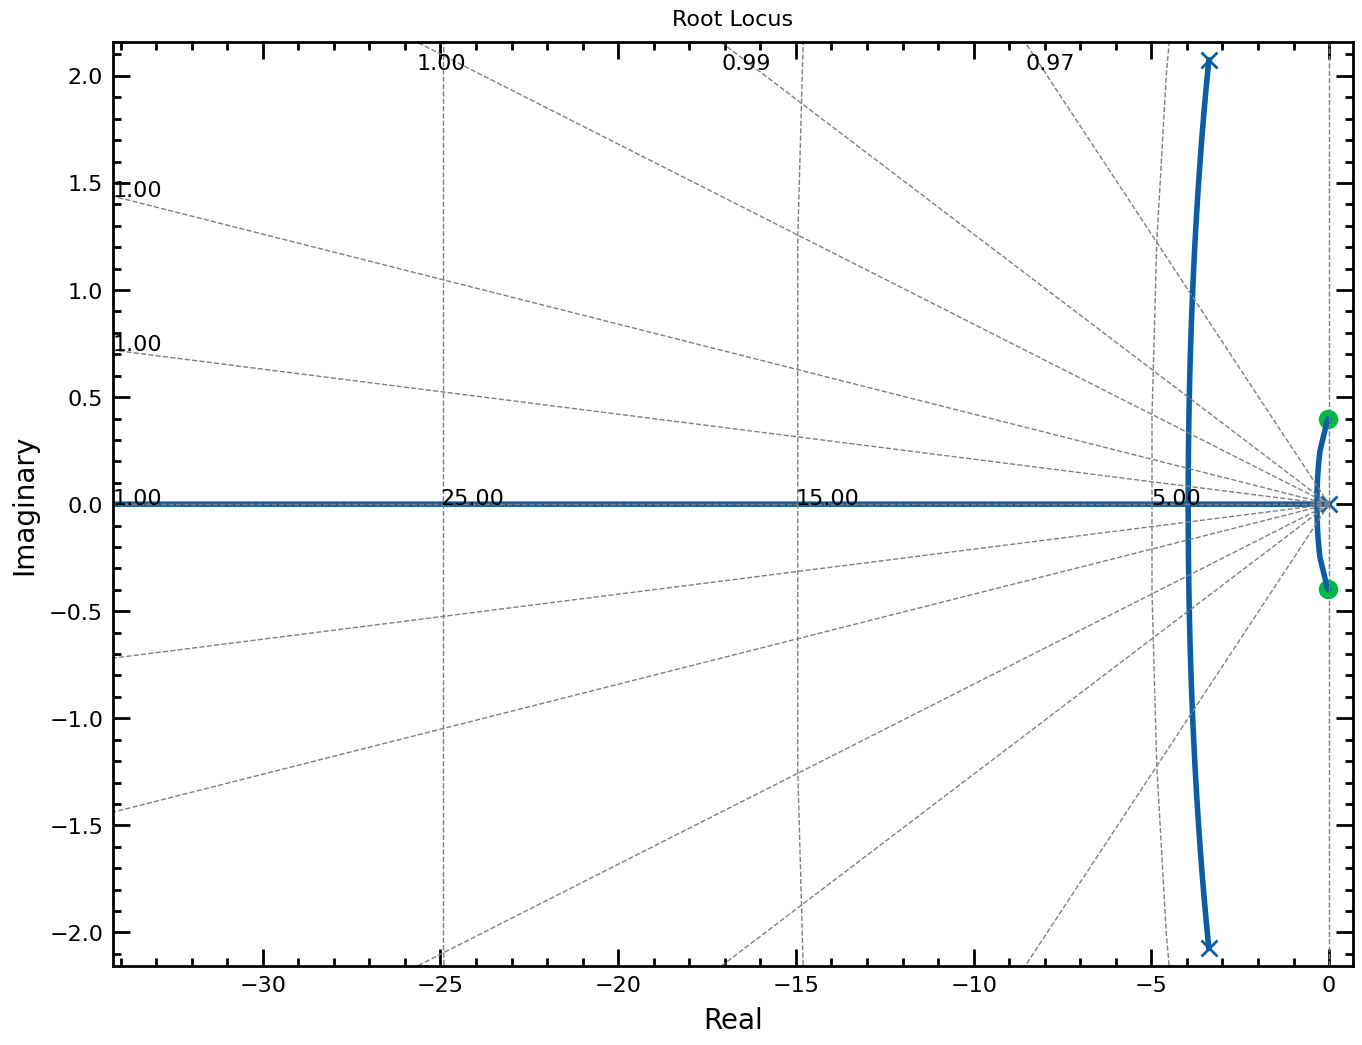

In [111]:
ct.rlocus(Gs*Gpid);

In [112]:
MF = ct.feedback(Gpid*Gs, 1, -1)
MF

TransferFunction(array([0.0030576 , 0.00017472, 0.00048048]), array([0.00098834, 0.00974434, 0.01573772, 0.00048048]))

In [113]:
u1 = np.array(sinal_entrada[50:] - np.mean(sinal_entrada[50:]))
yout = np.array(sinal_saida[50:] - np.mean((sinal_saida[50:])))
t = np.array(tempo[50:])

In [114]:
t_t = np.linspace(t[0], t[-1], len(t))
_, yp_c = ct.forced_response(Gs, U=1.5*np.rad2deg(u1), T=t_t)

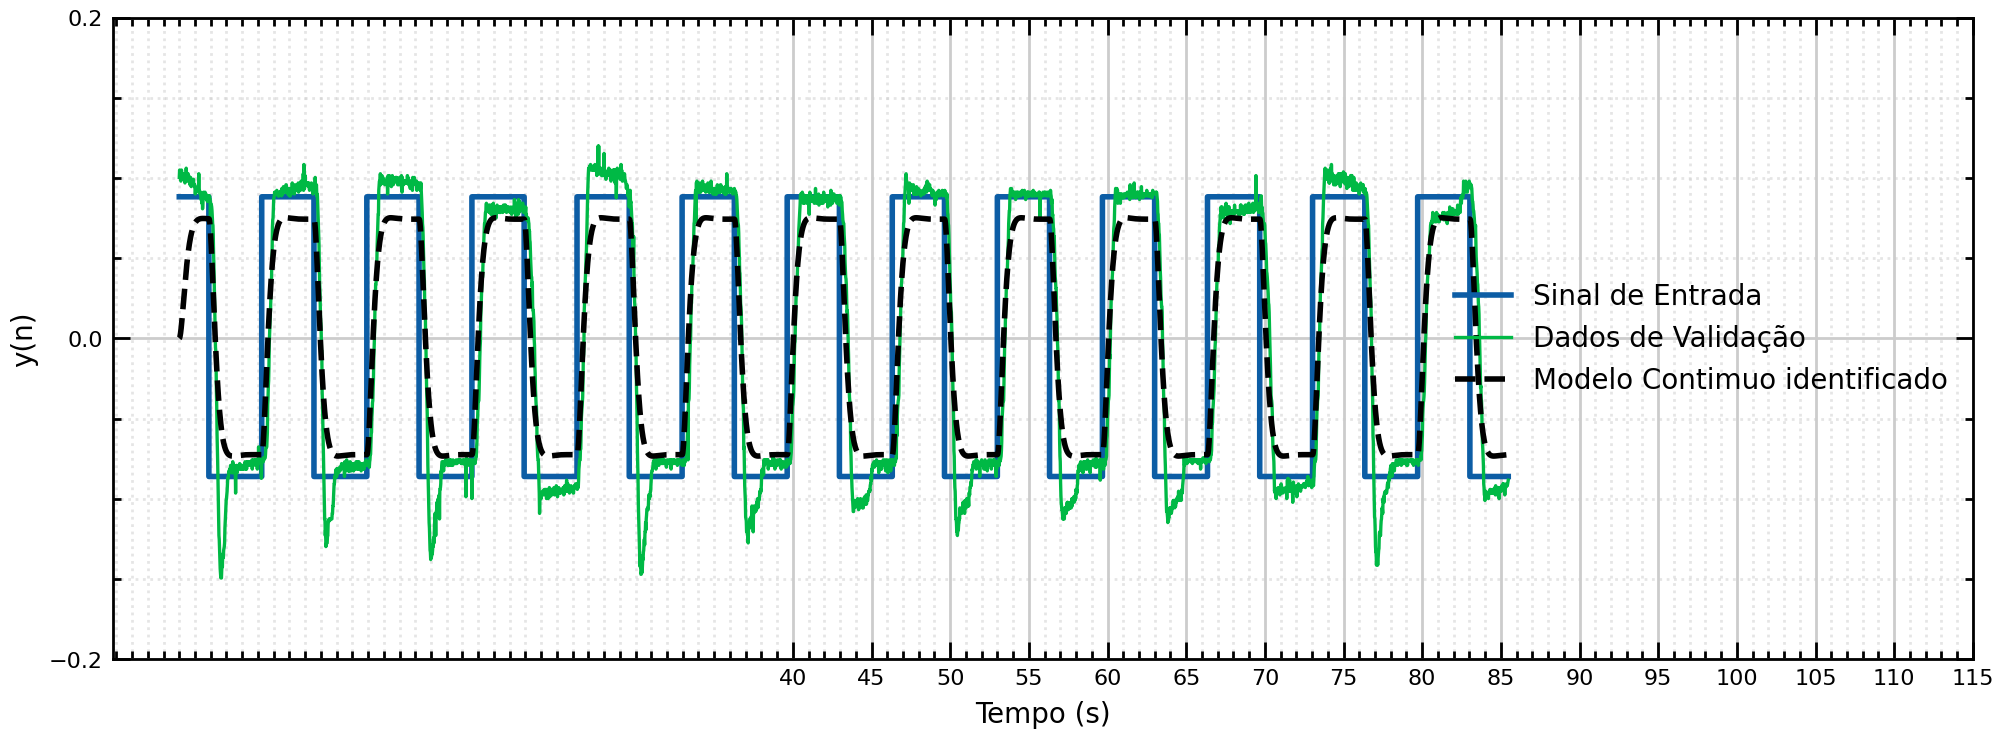

In [115]:
plt.figure(figsize = (12, 10))
plt.subplot(211)
plt.step(t, u1, label='Sinal de Entrada')
plt.plot(t, yout, linewidth = 1.2, label='Dados de Validação')
plt.plot(t, np.deg2rad(yp_c), linestyle='--', color='k', label='Modelo Contimuo identificado')
# plt.plot(t, yp_mf, linestyle='--', color='blue', label='Simulação MF')
plt.yticks(np.arange(-0.2, 0.3, 0.2))
plt.legend(fontsize=10, loc='center right')
plt.xticks(np.arange(40, 120, 5))

plt.grid(which='both')
plt.grid(which='major', color='#CCCCCC', linestyle='-', alpha=1)
plt.grid(which='minor', color='#CCCCCC', linestyle=':', alpha=0.5)

plt.ylabel('y(n)')
plt.xlabel('Tempo (s)')

plt.subplots_adjust(hspace=0.4)
plt.show()
